# Project invoices
*KUBIK Aleksander - KOBANA Johan - JOUYIT Matthieu - Thomas BOULAINE - DIA4*


Our problem : How can we analyze and visualize an online store’s activity using an invoice dataset to extract key indicators that support data-driven decisions?



In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import plotly_express as px

#faut qu'on fasse du pattern mining

In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)

    return df
invoice = load_data('invoices.csv')

In [3]:
#Basic info
def basic_info(data):
    print("Shape:", data.shape)
    print("\nColumns:", data.columns.tolist())

    print("\nData types:")
    print(data.dtypes)

    print("\nMissing values per column:")
    print(data.isna().sum())

basic_info(invoice)

Shape: (10000, 11)

Columns: ['first_name', 'last_name', 'email', 'product_id', 'qty', 'amount', 'invoice_date', 'address', 'city', 'stock_code', 'job']

Data types:
first_name       object
last_name        object
email            object
product_id        int64
qty               int64
amount          float64
invoice_date     object
address          object
city             object
stock_code        int64
job              object
dtype: object

Missing values per column:
first_name      0
last_name       0
email           0
product_id      0
qty             0
amount          0
invoice_date    0
address         0
city            0
stock_code      0
job             0
dtype: int64


In [4]:
def preprocess_dates(data):
    """
    Convert invoice_date to datetime and extract year/month.
    """
    data["invoice_date"] = pd.to_datetime(data["invoice_date"], format="%d/%m/%Y")
    data["year"] = data["invoice_date"].dt.year
    data["month"] = data["invoice_date"].dt.month
    return data

preprocess_dates(invoice)
invoice.head()


,first_name,last_name,email,product_id,qty,amount,invoice_date,address,city,stock_code,job,year,month
0,Carmen Nixon,Todd Anderson,marvinjackson@example.com,133,9,14.57,1982-09-10,283 Wendy Common,West Alexander,36239634,Logistics and distribution manager,1982,9
1,Mrs. Heather Miller,Julia Moore,jeffrey84@example.net,155,5,65.48,2012-10-03,13567 Patricia Circles Apt. 751,Andreamouth,2820163,Osteopath,2012,10
2,Crystal May,Philip Moody,ugoodman@example.com,151,9,24.66,1976-03-23,6389 Debbie Island Suite 470,Coxbury,27006726,Economist,1976,3
3,Bobby Weber,Mark Scott,ssanchez@example.com,143,4,21.34,1986-08-17,6362 Ashley Plaza Apt. 994,Ninaland,83036521,Sports administrator,1986,8
4,Kristen Welch,David David,cynthia66@example.net,168,2,83.90,1996-06-11,463 Steven Cliffs Suite 757,Isaiahview,80142652,Chief Marketing Officer,1996,6


Here we convert the `invoice_date` column into a real datetime format.  
We also create two new columns: `year` and `month`.

These will be useful later when we study trends in sales over time.

In [5]:
def sales_by_month(invoice):
    """
    Compute total monthly revenue based on 'amount'.
    """
    monthly_sales = invoice.groupby(["year", "month"])["amount"].sum().reset_index()
    monthly_sales["date"] = pd.to_datetime(
        monthly_sales["year"].astype(str) + "-" + monthly_sales["month"].astype(str) + "-01"
    )#vrm intéressant vu qu'on a déjà year et month ?
    return monthly_sales

monthly_sales = sales_by_month(invoice)
monthly_sales.head()


,year,month,amount,date
0,1970,1,776.42,1970-01-01
1,1970,2,1089.66,1970-02-01
2,1970,3,1147.24,1970-03-01
3,1970,4,522.42,1970-04-01
4,1970,5,411.65,1970-05-01


This function calculates the total sales for each month.  
We group the data by year and month, then sum the amounts.

It gives us our first time-based indicator: how the store’s sales evolve over time.

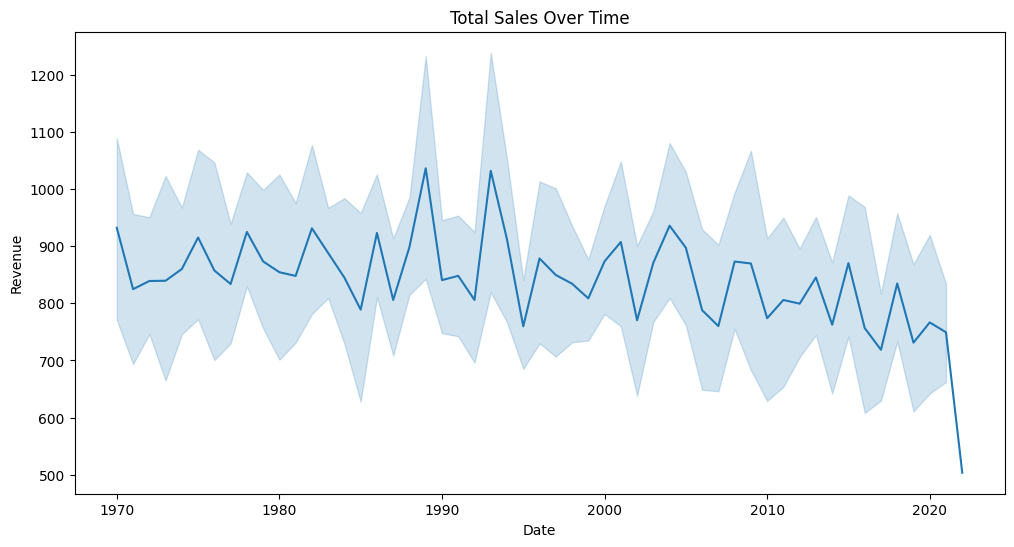

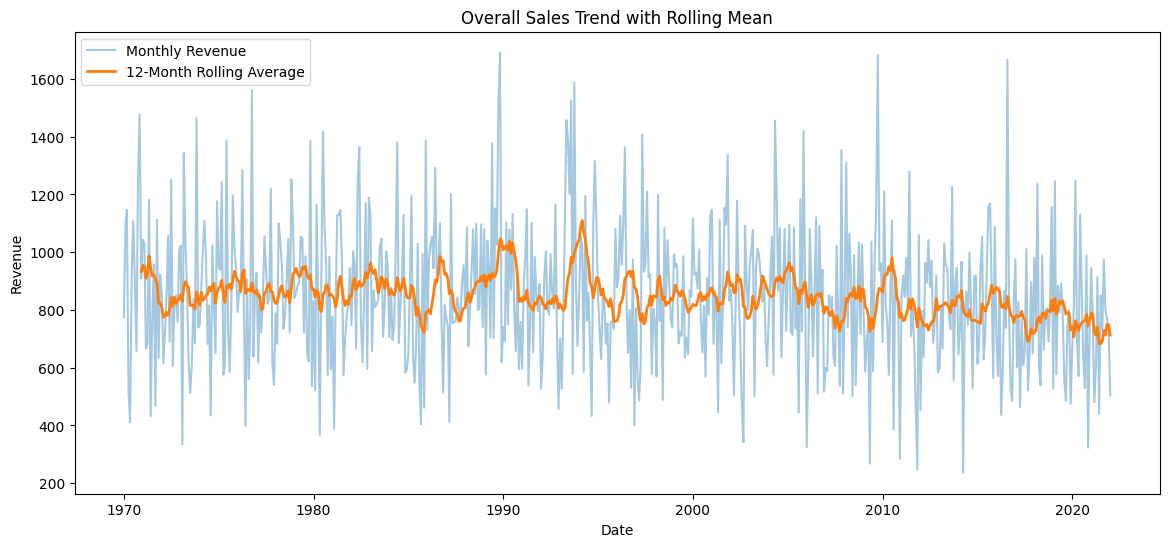

In [6]:
#à voir lequel est le plus parlant
def first_plot(sales):
    plt.figure(figsize=(12,6))
    sns.lineplot(data=sales, x="year", y="amount")
    plt.title("Total Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.show()

    sales['rolling_mean'] = sales['amount'].rolling(window=12).mean()
    plt.figure(figsize=(14,6))
    plt.plot(sales['date'], sales['amount'], alpha=0.4, label='Monthly Revenue')
    plt.plot(sales['date'], sales['rolling_mean'], linewidth=2, label='12-Month Rolling Average')
    plt.title("Overall Sales Trend with Rolling Mean")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()


first_plot(monthly_sales)

In [7]:
def top_products(invoice, n=10):
    """
    Identify the top N best-selling products (sum of quantities).
    """
    top = invoice.groupby("product_id")["qty"].sum().sort_values(ascending=False).head(n)
    return top

top10 = top_products(invoice)
top10


product_id
164    775
128    631
145    628
143    626
108    605
120    598
151    595
104    584
195    580
159    578
Name: qty, dtype: int64

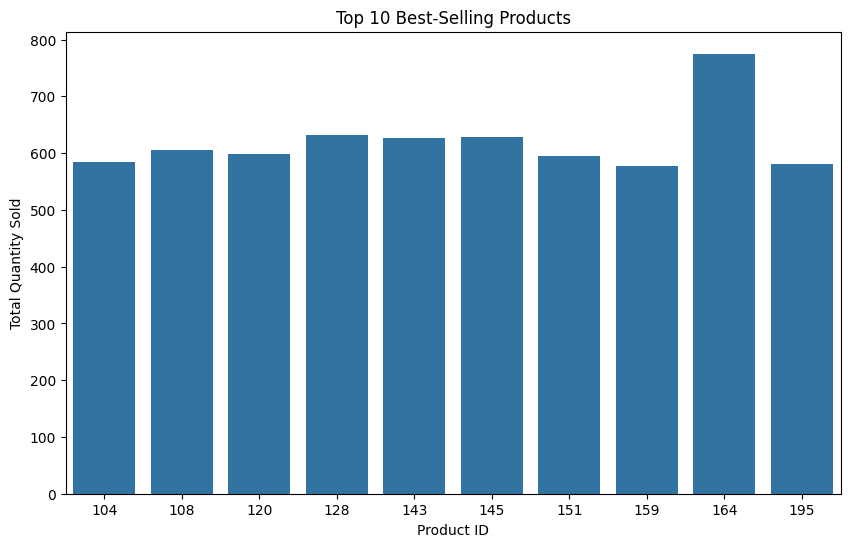

In [8]:
plt.figure(figsize=(10,6))
sns.barplot(x=top10.index, y=top10.values)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Product ID")
plt.ylabel("Total Quantity Sold")
plt.show()


In [9]:
def average_basket(invoice):
    """
    Compute the average spending per customer.
    """
    avg = invoice.groupby("email")["amount"].mean().reset_index()
    avg.rename(columns={"amount": "avg_basket"}, inplace=True)
    return avg

avg_basket = average_basket(invoice)
avg_basket.head()

,email,avg_basket
0,aadams@example.net,62.08
1,aallen@example.net,89.56
2,aallen@example.org,53.86
3,aalvarez@example.net,88.36
4,aaron23@example.com,32.12


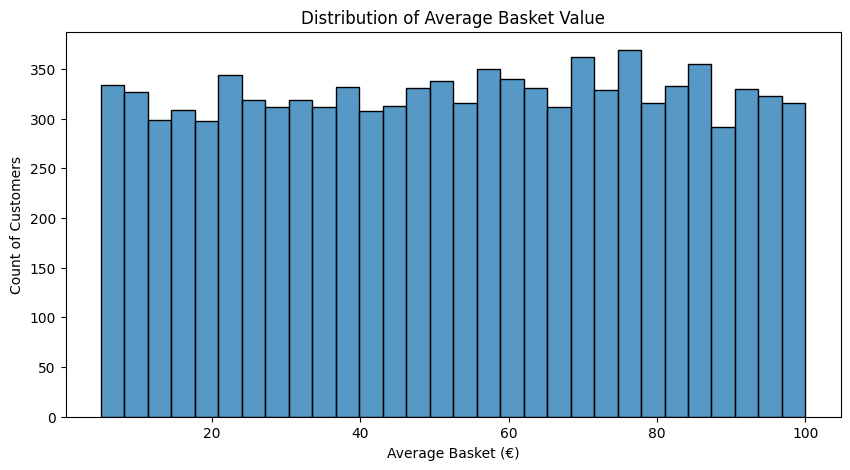

In [10]:
plt.figure(figsize=(10,5))
sns.histplot(avg_basket["avg_basket"], bins=30)
plt.title("Distribution of Average Basket Value")
plt.xlabel("Average Basket (€)")
plt.ylabel("Count of Customers")
plt.show()


In [11]:
def geo_clustering(invoice, k=4):
    """
    Apply KMeans clustering on cities using frequency of purchases.
    """
    city_counts = invoice["city"].value_counts().reset_index()
    city_counts.columns = ["city", "orders"]

    scaler = StandardScaler()
    city_counts["scaled"] = scaler.fit_transform(city_counts[["orders"]])

    kmeans = KMeans(n_clusters=k, random_state=0)
    city_counts["cluster"] = kmeans.fit_predict(city_counts[["scaled"]])

    return city_counts

clusters = geo_clustering(invoice, k=4)
clusters.head()


,city,orders,scaled,cluster
0,Lake James,12,14.126202,3
1,South James,10,11.489116,3
2,South David,9,10.170574,3
3,South Jennifer,9,10.170574,3
4,Lake Michael,9,10.170574,3


In [12]:
from dash import Dash, dcc, html
import dash_bootstrap_components as dbc

app = Dash(__name__)

app.layout = html.Div([
    html.H1("Invoices Dashboard", style={"text-align": "center"}),

    dcc.Graph(
        figure=px.line(monthly_sales, x="date", y="amount", title="Monthly Sales")
    ),

    dcc.Graph(
        figure=px.bar(top10, title="Top 10 Products")
    ),

    dcc.Graph(
        figure=px.histogram(avg_basket, x="avg_basket", title="Average Basket Distribution")
    ),

    dcc.Graph(
        figure=px.scatter(clusters, x="orders", y="scaled", color="cluster",
                          title="City Clusters")
    )
])

app.run(debug=False)
